In [605]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import glob
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%matplotlib inline

/Users/irarickman/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Executive Summary
Capital Bikeshare is a public bikesharing service founded in 2010, servicing the Washington DC metro area. The Bikeshare system contains about 4500 bikes and over 450 stations. Despite only 4500 bikes in circulation, there are a little over 8000 available spots at each station. Clearly, this can create challenges for Capital Bikeshare. Even at perfect distribution, every station would be slightly over 50% full. Even under normal circumstances, ensuring the right mixture of bikes at each station would be difficult, but given the complexities of population density, commuting, weather, and geography, bikeshare stations can easily be empty, leaving prospective riders without a bike or full, leaving riders without a dock. For my capstone, I have decided to study the effects that empty stations have on neighboring stations, to help determine which stations should be prioritized to refill bikes. 
To study this problem, I’ve gathered data from Capital Bikeshare on every trip taken between September 2010 and March 2017. The data contains the starting location, ending location, start time, end time, and the bike id. Using this data in conjunction with data on the capacity of each station, I was able to engineer a data set of the number of bikes taken in, taken out, moved in, and moved out for each hour between September 2010 and March 2017. To combat the unbalanced dispersion of bikes, Capital Bikeshare uses a practice called ‘rebalancing’ to move bikes from over-crowded stations to under-crowded stations. Using the dataset on the status of each bikeshare station, I created a dataset for each bikeshare station, organized by hour, containing the status of the station (empty, some bikes, full) and the average rate of bikes moving in and out for the 4 nearest stations.

### Approach
For my approach I plan to construct two separate analyses. The first analysis will be a Bayesian inference test of the difference in the average rate of bike movement for neighboring stations for each station, based on whether a station is empty or has bikes. Using this test, I hope to identify which stations have neighboring stations which experience higher rates of bike rental after running out of bikes. The result of this analysis will help identify bikeshare stations to prioritize for rebalancing. The second analysis will be a Markov Chain model of the flow of bikes between stations to model which stations are likeliest to become empty and thus need to be rebalanced. 

### Sorry my notebook is a mess, it will be clean by Thursday though!

In [603]:
files = glob.glob('../Data/*.csv')
# cols = pd.read_csv(files[len(files)-1]).columns
# bikes = pd.DataFrame(columns = cols)
# for bike in files:
#     data = pd.read_csv(bike)
#     bikes = bikes.append(data)

In [3]:
# only working with 2016 for now
len(files)
bikes = pd.DataFrame(columns = pd.read_csv(files[21]).columns)
for bike in files[21:26]:
    bikes=bikes.append(pd.read_csv(bike))

In [4]:
bikes.shape

(3333786, 10)

In [5]:
bikes.columns

Index([u'Account type', u'Bike number', u'Duration (ms)', u'End date',
       u'End station', u'End station number', u'Member Type', u'Start date',
       u'Start station', u'Start station number'],
      dtype='object')

In [6]:
bikes.head()

,Account type,Bike number,Duration (ms),End date,End station,End station number,Member Type,Start date,Start station,Start station number
0,NaN,W00022,301295,4/1/2016 0:04,1st & Rhode Island Ave NW,31506,Registered,3/31/2016 23:59,11th & S St NW,31280
1,NaN,W01294,557887,4/1/2016 0:08,18th St & Wyoming Ave NW,31114,Registered,3/31/2016 23:59,New Hampshire Ave & 24th St NW,31275
2,NaN,W01416,555944,4/1/2016 0:08,18th & M St NW,31221,Registered,3/31/2016 23:59,14th & V St NW,31101
3,NaN,W01090,766916,4/1/2016 0:09,17th & Corcoran St NW,31214,Registered,3/31/2016 23:57,34th St & Wisconsin Ave NW,31226
4,NaN,W21934,139656,3/31/2016 23:59,27th & Crystal Dr,31009,Registered,3/31/2016 23:57,23rd & Crystal Dr,31011


In [7]:
bikes['start'] = pd.to_datetime(bikes['Start date'], infer_datetime_format = True)
bikes['end'] = pd.to_datetime(bikes['End date'], infer_datetime_format = True)

In [8]:
bikes['start_year']=bikes.start.dt.year
bikes['end_year']=bikes.end.dt.year
bikes['start_month']=bikes.start.dt.month
bikes['end_month']=bikes.end.dt.month
bikes['start_day']=bikes.start.dt.day
bikes['end_day']=bikes.end.dt.day
bikes['start_hour'] = bikes.start.dt.hour
bikes['start_minute'] = bikes.start.dt.minute
bikes['end_hour'] = bikes.end.dt.hour
bikes['end_minute']=bikes.end.dt.minute
bikes['start_weekday'] = bikes.start.dt.weekday
bikes['end_weekday'] = bikes.end.dt.weekday
bikes['trip_time']=(bikes['Duration (ms)']/60000).astype(float)

In [9]:
weekdays = {i:day for i,day in enumerate(['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])}

In [10]:
bikes['start_day_name']=bikes.start_weekday.apply(lambda x: weekdays[x])
bikes['end_day_name']=bikes.end_weekday.apply(lambda x: weekdays[x])

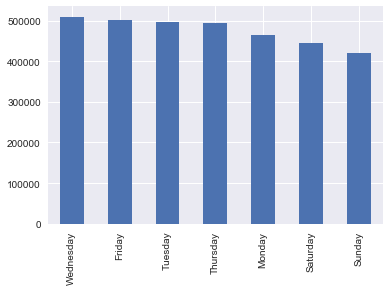

In [11]:
## what's the most common weekday?
bikes.start_day_name.value_counts().plot(kind='bar')

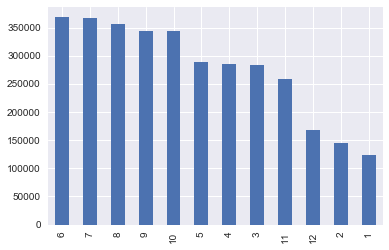

In [12]:
## What's the most common month?
bikes.start_month.value_counts().plot(kind='bar')

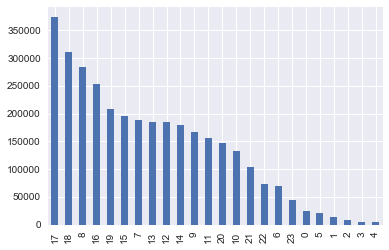

In [13]:
## What's the most common hour?
bikes.start_hour.value_counts().plot(kind='bar')

(array([  4.67560000e+05,   9.56446000e+05,   6.70996000e+05,
          4.29254000e+05,   2.78321000e+05,   1.63640000e+05,
          7.76280000e+04,   4.45640000e+04,   3.10080000e+04,
          2.55210000e+04,   2.13310000e+04,   1.82700000e+04,
          1.50010000e+04,   1.24690000e+04,   1.12710000e+04,
          1.02940000e+04,   9.60600000e+03,   8.53800000e+03,
          7.62900000e+03,   6.78500000e+03,   0.00000000e+00,
          5.27530000e+04,   7.86600000e+03,   2.21900000e+03,
          9.08000000e+02,   6.01000000e+02,   5.33000000e+02,
          4.88000000e+02,   4.87000000e+02]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100, 100, 200, 300, 400, 500,
        600, 700, 800, 900]),
 <a list of 29 Patch objects>)

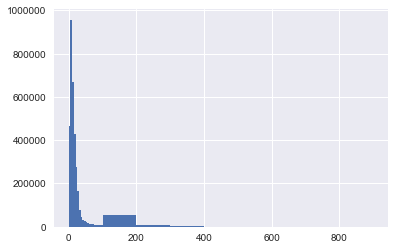

In [14]:
# Most of the trips are pretty short
bins = [x for x in range(0,101,5)] + [x for x in range(100,1000,100)]
plt.hist(bikes.trip_time, bins = bins)

In [15]:
## how many bikes are there an what's the median and mean number of trips on each?
print 'the Mean number of trips on each bike is {:.2f}'.format(bikes['Bike number'].value_counts().mean())
print 'the Median number of trips on each bike is {:.2f}'.format(bikes['Bike number'].value_counts().median())
print 'There are {} unique bikes'.format(bikes['Bike number'].nunique())

the Mean number of trips on each bike is 749.17
the Median number of trips on each bike is 802.00
There are 4450 unique bikes


(array([ 225.,  190.,  296.,  471.,  705.,  874.,  984.,  574.,  119.,   12.]),
 array([  1.00000000e+00,   1.48700000e+02,   2.96400000e+02,
          4.44100000e+02,   5.91800000e+02,   7.39500000e+02,
          8.87200000e+02,   1.03490000e+03,   1.18260000e+03,
          1.33030000e+03,   1.47800000e+03]),
 <a list of 10 Patch objects>)

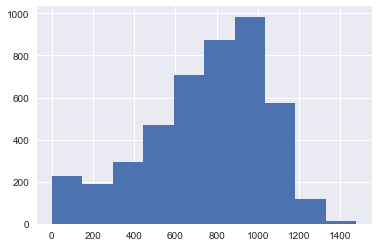

In [16]:
## histogram of rides
plt.hist(bikes['Bike number'].value_counts())

In [17]:
print bikes['Account type'].isnull().sum()
print bikes['Member Type'].isnull().sum()
bikes['Type']=bikes['Member Type'].fillna(bikes['Account type'])
bikes.Type.value_counts()

2391454
942332


Registered    2601521
Casual         732265
Name: Type, dtype: int64

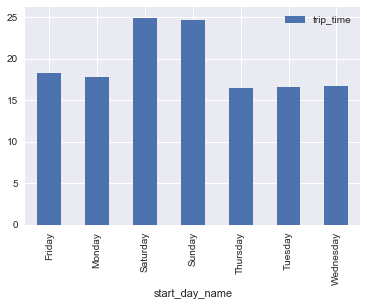

In [18]:
bikes.groupby('start_day_name')['Type','trip_time'].mean().plot(kind='bar')

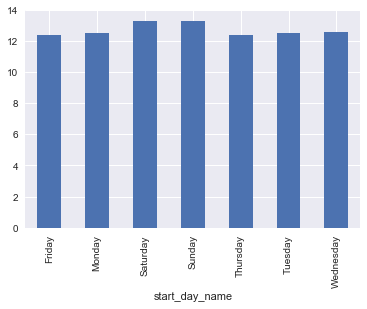

In [19]:
bikes[bikes.Type=='Registered'].groupby('start_day_name').trip_time.mean().plot(kind='bar')

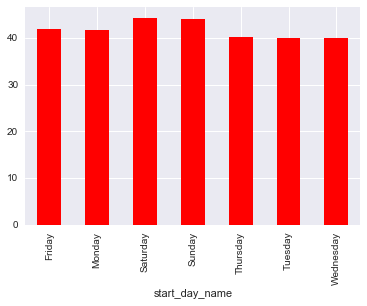

In [20]:
bikes[bikes.Type=='Casual'].groupby('start_day_name').trip_time.mean().plot(kind='bar', color='r')

In [21]:
print bikes.groupby('Type').trip_time.mean()
print bikes.groupby('Type').trip_time.count()

Type
Casual        42.303157
Registered    12.660977
Name: trip_time, dtype: float64
Type
Casual         732265
Registered    2601521
Name: trip_time, dtype: int64


In [22]:
dums=pd.get_dummies(bikes['End station number'])
all_bikes= pd.concat([bikes, dums], axis=1)

In [23]:
all_bikes.iloc[:5,28:]

,31000,31001,31002,31003,31004,31005,31006,31007,31008,31009,...,32211,32212,32213,32214,32215,32216,32218,32219,32221,32222
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [334]:
## restarting analysis to go one by one, generating an hourly status for each station
q1_17=pd.read_csv(files[26])
q1_17.columns

Index([u'Duration', u'Start date', u'End date', u'Start station number',
       u'Start station', u'End station number', u'End station', u'Bike number',
       u'Member Type'],
      dtype='object')

In [488]:
## fixing the 2013 Q2 file
bike = '../2013-Q2-cabi-trip-history-data-original.csv'
bikes = pd.read_csv(bike)
#bikes.head()
temp_10=bikes.merge(stations_list[['name','short_name']], left_on='Start Station', right_on='name', how='left').drop('name', axis=1).rename(columns={'short_name':'Start station number'})
fix=temp_10.merge(stations_list[['name', 'short_name']], left_on = 'End Station', right_on = 'name', how = 'left').drop('name', axis = 1).rename(columns = {'short_name':'End station number'})
fix.to_csv('../data/2013-Q2-cabi-trip-history-data-fixed.csv', index=False)

In [685]:
def make_dates(df):
    cols = set(df.columns)
    if 'Start date' in cols:
        st= 'Start date'
        end = 'End date'
    elif 'Start time' in cols:
        st= 'Start time'
        end = 'End date'
    df['start']=pd.to_datetime(df[st],infer_datetime_format=True)
    df['end']=pd.to_datetime(df[end],infer_datetime_format=True)
    df['start_year']=df.start.dt.year
    df['end_year']=df.end.dt.year
    df['start_month']=df.start.dt.month
    df['end_month']=df.end.dt.month
    df['start_day']=df.start.dt.day
    df['end_day']=df.end.dt.day
    df['start_hour'] = df.start.dt.hour
    df['start_minute'] = df.start.dt.minute
    df['end_hour'] = df.end.dt.hour
    df['end_minute']=df.end.dt.minute
    df['start_weekday'] = df.start.dt.weekday
    df['end_weekday'] = df.end.dt.weekday
    if 'Duration' in cols:
        dur = 'Duration'
    elif 'Duration (ms)' in cols:
        dur = 'Duration (ms)'
    elif 'Total duration (ms)' in cols:
        dur = 'Total duration (ms)'
    try:
        df['trip_time']=(df[dur].astype(float)/60000).astype(float)
    except ValueError:
        df['trip_time']=0
    df['start']=df.start.map(lambda x: x.strftime('%Y-%m-%d %H'))

In [686]:
def rename(df):
    cols = set(df.columns)
    df.dropna(axis=0, inplace=True)
    if 'Start station number' not in cols:
        if 'Start station' in cols:
            df['Start station number']= (df['Start station'].str.replace('(Dupont Circle south)','0').astype(str).str.extract(r"\((.*?)\)")).astype(float)
            start_stat = 'Start station number'
        elif 'Start Station' in cols:
            df['Start station number']= (df['Start Station'].str.replace('(Dupont Circle south)','0').astype(str).str.extract(r"\((.*?)\)")).astype(float)
            start_stat = 'Start station number'
    if 'End station number' not in cols:
        if 'End station' in cols:
            df['End station number']= (df['End station'].str.replace('(Dupont Circle south)','0').astype(str).str.extract(r"\((.*?)\)")).astype(float)
            end_stat = 'End station number'
        elif 'End Station' in cols:
            df['End station number']= (df['End Station'].str.replace('(Dupont Circle south)','0').astype(str).str.extract(r"\((.*?)\)")).astype(float)
            end_stat = 'End station number'
    if 'End station number' in cols:
        end_stat = 'End station number'
    new_end = 'end_stat'
    if 'Start station number' in cols:
        start_stat = 'Start station number'
    new_start = 'start_stat'
    if 'Bike number' in cols:
        bike_num = 'Bike number'
    elif 'Bike #' in cols:
        bike_num = 'Bike #'
    elif 'Bike#' in cols:
        bike_num = 'Bike#'
    new_bike = 'bike_id'
    if 'Member Type' in cols:
        mem = 'Member Type'
    elif 'Member type' in cols:
        mem = 'Member type'
    elif 'Account type' in cols:
        mem = 'Account type'
    elif 'Type' in cols:
        mem= 'Type'
    elif 'Subscription type' in cols:
        mem = 'Subscription type'
    elif 'Subscription Type' in cols:
        mem = 'Subscription Type'
    elif 'Subscriber Type' in cols:
        mem = 'Subscriber Type'
    elif 'Bike Key' in cols:
        mem = 'Bike Key'    
    new_mem='type'
    df.rename(columns = {end_stat:new_end, start_stat:new_start, bike_num:new_bike, mem:new_mem},inplace=True)

In [786]:
def station_hours(df, start_date='', end_date=''):
    '''This function takes in a period of bikeshare data, then pumps out a dicitionary of data frames of the per hour movement 
    of bikes within the station. It also generates new hour periods and trims columns'''
    if start_date=='':
        start_date=df.start.min()
        end_date=df.start.max()
    ix = pd.DatetimeIndex(start=pd.to_datetime(start_date), end=pd.to_datetime(end_date), freq='H')
    hours = pd.DataFrame(ix.map(lambda x: x.strftime('%Y-%m-%d %H')), columns = ['start'])
    stats = {}
    racks = df.start_stat.unique()
    dc_racks = get_dc()
    for rack in dc_racks:
        rack = float(rack)
        try:
            temp=df[(df['start_stat']==rack)|(df['end_stat']==rack)].copy(deep=True)
            temp['moved_in']=temp[temp['start_stat']==rack].moved
            temp['moved_out']=temp[temp['end_stat']==rack].moved
            temp['in']= (temp.end_stat==rack).astype(int)
            temp['out']=(temp.start_stat==rack).astype(int)
            temp_temp = temp.drop(['end_stat', 'start_stat', 'moved'], axis=1)
            temp_grp = temp_temp.groupby(temp_temp['start']).sum().reset_index()
            temp_all = hours.merge(temp_grp, how = 'left', on = 'start')
            temp_all.fillna(0, inplace=True)
            stats[rack]=temp_all.copy(deep=True)
        except TypeError:
            print type(rack), type(df.loc[0,'start_stat']), type(df.loc[0,'end_stat'])
            pass
    return stats

def get_dc():
    url = 'https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json'
    r = requests.get(url)
    results = r.json()['data']['stations']
    stations_list=pd.DataFrame.from_dict(results, orient='columns')
    ## only regions 41 and 42 are in DC and Virginia, so I'll only use those
    dc_va=stations_list[(stations_list.region_id==41)|(stations_list.region_id==42)].copy(deep=True)
    dc_stations=set(dc_va.short_name.unique())
    return dc_stations

In [789]:
def save_stations(data,path):
    '''This function takes in a dictionary of station data frames then saves them to my folder'''
    for station in data.keys():
        data[station].to_csv('../cap_data' + path + '_'+ str(station) + '.csv', index=False)

In [784]:
## defining my cleaning functions

def prev_station(df):
    df['previous']=df.sort_values(['bike_id','start']).groupby('bike_id')['end_stat'].shift(1)
    df['previous'].fillna(df['end_stat'])
    
def moved(df):
    df['moved']=(df['start_stat']!=df['previous']).astype(int)
    
def drop_cols(df):
    cols=set(df.columns)
    if 'Duration' in cols:
        dur = 'Duration'
    elif 'Duration (ms)' in cols:
        dur = 'Duration (ms)'
    elif 'Total duration (ms)' in cols:
        dur = 'Total duration (ms)'
    if 'Start date' in cols:
        st= 'Start date'
        end = 'End date'
    elif 'Start time' in cols:
        st= 'Start time'
        end = 'End date'
    if 'Start Station' in cols:
        st_stat = 'Start Station'
    elif "Start station" in cols:
        st_stat ='Start station'
    if 'End Station' in cols:
        e_stat = 'End Station'
    elif "End station" in cols:
        e_stat ='End station'
    df.drop([dur, st, end, 'end', 'previous','trip_time','bike_id','type', 'start_weekday', 'end_weekday', 'start_minute', 'end_minute', st_stat, e_stat, 'end_year', 'end_month', 'end_day','end_hour', 'start_year', 'start_month', 'start_day', 'start_hour'], axis=1, inplace=True)


In [681]:
make_dates(q1_17)

In [276]:
rename(q1_17)

In [277]:
prev_station(q1_17)

In [278]:
moved(q1_17)

In [279]:
drop_cols(q1_17)

In [280]:
q1_17.columns

Index([u'start_stat', u'end_stat', u'start', u'moved'], dtype='object')

In [281]:
stats=station_hours(q1_17,'2017/01/01','2017/02/01' )

In [779]:
stats[31280].tail()

,start,moved_in,moved_out,in,out
2155,2017-03-31 19,0.0,0.0,0.0,0.0
2156,2017-03-31 20,0.0,0.0,0.0,0.0
2157,2017-03-31 21,0.0,0.0,0.0,1.0
2158,2017-03-31 22,0.0,0.0,1.0,0.0
2159,2017-03-31 23,0.0,0.0,0.0,0.0


In [252]:
ix = pd.DatetimeIndex(start=pd.to_datetime('2017/01/01'), end=pd.to_datetime('2017/02/01'), freq='H')
hours = pd.DataFrame(ix.map(lambda x: x.strftime('%Y-%m-%d %H')), columns = ['start'])
test = stats[31280].reset_index()
hours.merge(test, how = 'left', on = 'start')


,start,moved_in,moved_out,in,out,station
0,2017-01-01 00,0.0,1.0,1.0,0.0,31280.0
1,2017-01-01 01,0.0,2.0,2.0,1.0,93840.0
2,2017-01-01 02,1.0,0.0,1.0,1.0,62560.0
3,2017-01-01 03,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 04,NaN,NaN,NaN,NaN,NaN
5,2017-01-01 05,NaN,NaN,NaN,NaN,NaN
6,2017-01-01 06,NaN,NaN,NaN,NaN,NaN
7,2017-01-01 07,0.0,1.0,1.0,0.0,31280.0
8,2017-01-01 08,0.0,2.0,2.0,1.0,93840.0
9,2017-01-01 09,NaN,NaN,NaN,NaN,NaN


In [432]:
# figuring out how to configure my functions for each file
standard = set(pd.read_csv(files[26]).columns)
for bike in files:
    print [x for x in pd.read_csv(bike).columns if x not in standard], [x for x in pd.read_csv(bike).columns if x in standard]

['Bike#'] ['Duration', 'Start date', 'End date', 'Start station', 'End station', 'Member Type']
['Bike#'] ['Duration', 'Start date', 'End date', 'Start station', 'End station', 'Member Type']
['Bike#'] ['Duration', 'Start date', 'End date', 'Start station', 'End station', 'Member Type']
['Bike#'] ['Duration', 'Start date', 'End date', 'Start station', 'End station', 'Member Type']
['Bike#'] ['Duration', 'Start date', 'End date', 'Start station', 'End station', 'Member Type']
['Start Station', 'End Station', 'Bike#', 'Type'] ['Duration', 'Start date', 'End date']
['Start Station', 'End Station', 'Bike#', 'Bike Key'] ['Duration', 'Start date', 'End date']
['Start Station', 'End Station', 'Bike#', 'Subscriber Type'] ['Duration', 'Start date', 'End date']
['Start Station', 'End Station', 'Bike#', 'Subscription Type'] ['Duration', 'Start date', 'End date']
['Start Station', 'End Station', 'Bike#', 'Subscription Type'] ['Duration', 'Start date', 'End date']
['Start time', 'Start Station', 'E

In [ ]:
first.dropna()

In [415]:
first['End station'].str.replace('(Dupont Circle South)','').astype(str).str.extract(r"\((.*?)\)")

/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


0         31111
1         31202
2         31401
3         31401
4         31623
5         31111
6         31111
7         31623
8         31402
9         31103
10        31237
11        31229
12        31104
13        31228
14        31202
15        31104
16        31238
17        31619
18        31619
19        31106
20        31623
21        31101
22        31101
23        31102
24        31229
25        31607
26        31622
27        31611
28        31605
29        31200
          ...  
117662    31100
117663    31100
117664    31602
117665    31100
117666    31601
117667    31601
117668    31209
117669    31108
117670    31007
117671    31007
117672    31011
117673    31011
117674    31007
117675    31007
117676    31007
117677    31007
117678    31007
117679    31007
117680    31007
117681    31208
117682    31400
117683    31202
117684    31101
117685    31101
117686    31101
117687    31101
117688    31101
117689    31101
117690    31500
117691    31009
Name: End station, Lengt

In [514]:
timer=pd.read_csv(files[20])
timer.dropna(axis=0).dtypes

Duration (ms)            int64
Start date              object
End date                object
Start station number     int64
Start station           object
End station number       int64
End station             object
Bike #                  object
Member type             object
dtype: object

In [392]:
first=pd.read_csv(files[0])
#starts = first['Start station'].unique()
bads =[]
import re
for num in first['End station']:
    try:
        got=re.search(r"\((.*?)\)", str(num)).group(1)
    except (AttributeError,ValueError):   
        print num
        bads.append(num)
        pass

# figure out why start station number is unicode

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [588]:
find_err = []
for b in bikes['Start station']:
    find_err.append(float(re.search(r"\((.*?)\)",str(b).replace('(Dupont Circle south)','')).group(1)))
set(find_err)
# for x in bikes['Start station'].str.replace('(Dupont Circle south)','').astype(str).str.extract(r"\((.*?)\)"):
#     print float(x)
bikes['test_num']=bikes['Start station'].str.replace('(Dupont Circle south)','0').astype(str).str.extract(r"\((.*?)\)")
#pd.options.display.max_rows=1000
#print bikes.loc[96300:96400,'test_num']

/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  import sys


In [691]:
early_bikes = pd.read_csv(files[0])
early_bikes.head()

,Duration,Start date,End date,Start station,End station,Bike#,Member Type
0,14h 26min. 2sec.,12/31/2010 23:49,1/1/2011 14:15,10th & U St NW (31111),10th & U St NW (31111),W00771,Casual
1,0h 8min. 34sec.,12/31/2010 23:37,12/31/2010 23:46,10th & U St NW (31111),14th & R St NW (31202),W01119,Registered
2,0h 12min. 17sec.,12/31/2010 23:27,12/31/2010 23:39,Park Rd & Holmead Pl NW (31602),14th St & Spring Rd NW (31401),W00973,Registered
3,0h 15min. 53sec.,12/31/2010 23:21,12/31/2010 23:37,Calvert St & Woodley Pl NW (31106),14th St & Spring Rd NW (31401),W00914,Registered
4,0h 36min. 19sec.,12/31/2010 23:20,12/31/2010 23:56,20th St & Florida Ave NW (31110),Columbus Circle / Union Station (31623),W00859,Casual


In [795]:
## looping through all the files and converting them, then exporting them
import time
start_time = time.time()
final_stats = get_dc()
final_stations = [float(x) for x in final_stats]
for bike in files:
    print bike
    stats=''
    nm = bike[7:-4]
    bikes = pd.read_csv(bike)
    make_dates(bikes)
    rename(bikes)
    prev_station(bikes)
    moved(bikes)
    drop_cols(bikes)
    stats = station_hours(bikes)
    save_stations(stats, nm)
    
time2 = time.time()
print str((time2 - start_time)/60.) + ' minutes to run'

../Data/2010-Q4-cabi-trip-history-data.csv


/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  
/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  del sys.path[0]


../Data/2011-Q1-cabi-trip-history-data.csv
../Data/2011-Q2-cabi-trip-history-data.csv
../Data/2011-Q3-cabi-trip-history-data.csv
../Data/2011-Q4-cabi-trip-history-data.csv
../Data/2012-Q1-cabi-trip-history-data.csv


/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  if __name__ == '__main__':
/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  app.launch_new_instance()


../Data/2012-Q2-cabi-trip-history-data.csv
../Data/2012-Q3-cabi-trip-history-data.csv
../Data/2012-Q4-cabi-trip-history-data.csv
../Data/2013-Q1-cabi-trip-history-data.csv
../Data/2013-Q2-cabi-trip-history-data-fixed.csv
../Data/2013-Q3-cabi-trip-history-data.csv
../Data/2013-Q4-cabi-trip-history-data.csv
../Data/2014-Q1-cabi-trip-history-data.csv
../Data/2014-Q2-cabi-trip-history-data.csv
../Data/2014-Q3-cabi-trip-history-data.csv
../Data/2014-Q4-cabi-trip-history-data.csv
../Data/2015-Q1-Trips-History-Data.csv
../Data/2015-Q2-Trips-History-Data.csv
../Data/2015-Q3-cabi-trip-history-data.csv
../Data/2015-Q4-Trips-History-Data.csv
../Data/2016-Q1-Trips-History-Data.csv
../Data/2016-Q2-Trips-History-Data.csv
../Data/2016-Q3-Trips-History-Data-1.csv
../Data/2016-Q3-Trips-History-Data-2.csv
../Data/2016-Q4-Trips-History-Data.csv
../Data/2017-Q1-Trips-History-Data 2.csv
18.3610994498 minutes to run


In [796]:
## storing each bike station in it's own file to make it easier to work with
start_time = time.time()
loop_stats = [str(x) for x in final_stations]
for stat in loop_stats:
    bike_data= glob.glob('../cap_data/*' + stat + '.csv')
    bike_df = pd.DataFrame(columns = pd.read_csv(bike_data[0]).columns)
    for bike_st in bike_data:
        bike_df=bike_df.append(pd.read_csv(bike_st))
    bike_df_1 = bike_df.drop(['station'],axis=1).drop_duplicates()
    bike_df_2 = bike_df_1.groupby('start').sum().reset_index()
    bike_df_2.to_csv('../cap_data/stations/' + stat + '_data.csv', index=False)
time2 = time.time()
print str((time2 - start_time)/60.) + ' minutes to run'

4.782941703 minutes to run


In [716]:
bike_df_1.head()

,in,moved_in,moved_out,out,start
0,0.0,0.0,0.0,0.0,2010-09-15 14
1,0.0,0.0,0.0,0.0,2010-09-15 15
2,0.0,0.0,0.0,0.0,2010-09-15 16
3,0.0,0.0,0.0,0.0,2010-09-15 17
4,0.0,0.0,0.0,0.0,2010-09-15 18


In [729]:
stat_files = glob.glob('../cap_data/stations/*_data.csv')
to_test = ['in', 'out', 'moved_in', 'moved_out']
for stop in stat_files:    
    df_test=pd.read_csv(stop)
    df_test['net']=df_test['in']+df_test['moved_in']-df_test['moved_out']-df_test['out']
    df_test['run']=df_test.net.cumsum()
    print df_test.run.max(), df_test.run.min()
    print df_test.loc[len(df_test)-1,'run']

3.0 -100.0
-25.0
2.0 -240.0
-122.0
1052.0 -7.0
1042.0
7.0 -225.0
-119.0
141.0 -26.0
132.0
20.0 -493.0
-490.0
598.0 -29.0
594.0
0.0 -1774.0
-1773.0
38.0 -56.0
12.0
124.0 -335.0
-217.0
950.0 -10.0
950.0
882.0 -14.0
874.0
119.0 -32.0
115.0
496.0 -2.0
496.0
3793.0 -122.0
3788.0
2351.0 -185.0
2346.0
2.0 -1310.0
-1308.0
3.0 -981.0
-976.0
5.0 -676.0
-658.0
0.0 -773.0
-770.0
6.0 -824.0
-824.0
2.0 -846.0
-843.0
4.0 -1582.0
-1582.0
3.0 -827.0
-813.0
6.0 -1414.0
-1410.0
10.0 -497.0
-486.0
0.0 -649.0
-648.0
3.0 -626.0
-624.0
0.0 -629.0
-624.0
6.0 -963.0
-959.0
2.0 -1403.0
-1403.0
1.0 -477.0
-474.0
1.0 -272.0
-234.0
2.0 -375.0
-351.0
0.0 -657.0
-611.0
8.0 -646.0
-634.0
2.0 -425.0
-416.0
2.0 -1764.0
-1763.0
1.0 -413.0
-392.0
3.0 -895.0
-890.0
6.0 -478.0
-475.0
1.0 -489.0
-483.0
1.0 -408.0
-371.0
462.0 -19.0
450.0
228.0 0.0
223.0
4.0 -307.0
-304.0
133.0 0.0
112.0
226.0 -15.0
226.0
107.0 -9.0
80.0
98.0 -29.0
94.0
49.0 -13.0
49.0
229.0 -4.0
224.0
138.0 -14.0
135.0
119.0 -3.0
113.0
56.0 -12.0
53.0
132.0

In [959]:
# practicing making grouped cumulative sums
diff_df=pd.read_csv(stat_files[300])
diff_df['date']=diff_df['start'].apply(lambda x: x.split(' ')[0])
diff_df['hour']=diff_df['start'].apply(lambda x: x.split(' ')[1]).astype(int)
diff_df['group']=diff_df.hour.apply(lambda x: 'am_1' if x<7 else 'am_2' if x<13 else 'pm_1' if x<19 else 'pm_2' )
day_df=diff_df.drop(['start', 'hour','group'], axis=1).groupby('date').sum().reset_index()
per_df=diff_df.drop(['start','hour'], axis=1).groupby(['date', 'group']).sum().reset_index()
day_df['net']=day_df['in']+day_df['moved_in'] - day_df['out']-day_df['moved_out']
per_df['net']=per_df['in']+per_df['moved_in'] - per_df['out']-per_df['moved_out']
day_df['status']=day_df.groupby('date').net.cumsum()
day_cols = list(day_df.columns)
per_df['status']=per_df.groupby('date').net.cumsum()
per_cols= list(per_df.columns)
day_cols.append('station')
per_cols.append('station')
print day_df.tail()
print per_df.tail()

            date     in  moved_in  moved_out   out   net  status
2385  2017-03-27  100.0      51.0       52.0  84.0  15.0    15.0
2386  2017-03-28   89.0      34.0       41.0  71.0  11.0    11.0
2387  2017-03-29   90.0      39.0       42.0  72.0  15.0    15.0
2388  2017-03-30   74.0      37.0       29.0  74.0   8.0     8.0
2389  2017-03-31   27.0      10.0        7.0  24.0   6.0     6.0
            date group    in  moved_in  moved_out   out  net  status
9553  2017-03-30  pm_2  13.0      11.0        5.0  13.0  6.0     8.0
9554  2017-03-31  am_1   0.0       0.0        0.0   2.0 -2.0    -2.0
9555  2017-03-31  am_2   3.0       0.0        0.0   3.0  0.0    -2.0
9556  2017-03-31  pm_1  21.0       8.0        7.0  14.0  8.0     6.0
9557  2017-03-31  pm_2   3.0       2.0        0.0   5.0  0.0     6.0


In [964]:
min(per_df[(per_df['in']!=0)|(per_df['out']!=0)|(per_df['moved_in']!=0)|(per_df['moved_out']!=0)].index)

6998

In [965]:
# making the dataframes for all stations by day and by 6 hour block
start_time=time.time()
count=0
stat_files = glob.glob('../cap_data/stations/*_data.csv')
days_df =pd.DataFrame(columns = day_cols)
pers_df =pd.DataFrame(columns = per_cols)
for st in stat_files:
    d = pd.read_csv(st)
    d['date']=diff_df['start'].apply(lambda x: x.split(' ')[0])
    d['hour']=d['start'].apply(lambda x: x.split(' ')[1]).astype(int)
    d['group']=d.hour.apply(lambda x: 'am_1' if x<7 else 'am_2' if x<13 else 'pm_1' if x<19 else 'pm_2' )
    day=d.drop(['start', 'hour','group'], axis=1).groupby('date').sum().reset_index()
    per=d.drop(['start','hour'], axis=1).groupby(['date', 'group']).sum().reset_index()
    day['net']=day['in']+day['moved_in'] - day['out']-day['moved_out']
    per['net']=per['in']+per['moved_in'] - per['out']-per['moved_out']
    day['status']=day.groupby('date').net.cumsum()
    day['station']=st[-16:-9]
    per['status']=per.groupby('date').net.cumsum()
    day_m=min(per[(per['in']!=0)|(per['out']!=0)|(per['moved_in']!=0)|(per['moved_out']!=0)].index)
    per_m=min(day[(day['in']!=0)|(day['out']!=0)|(day['moved_in']!=0)|(day['moved_out']!=0)].index)
    per['station']=st[-16:-9]
    days_df=days_df.append(day[day_m:])
    pers_df=pers_df.append(per[per_m:])
    count+=1
    if count%10==0:
        print str(count) + ' ' + str((time.time()-start_time)/60.) + ' minutes in'
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

10 0.0331103801727 minutes in
20 0.0684653321902 minutes in
30 0.106854649385 minutes in
40 0.147202213605 minutes in
50 0.191139483452 minutes in
60 0.237995084127 minutes in
70 0.28673513333 minutes in
80 0.33828450044 minutes in
90 0.392851332823 minutes in
100 0.451814214389 minutes in
110 0.512748682499 minutes in
120 0.578184247017 minutes in
130 0.646630700429 minutes in
140 0.719760715961 minutes in
150 0.796036664645 minutes in
160 0.875209116936 minutes in
170 0.958156096935 minutes in
180 1.04309191704 minutes in
190 1.13101073106 minutes in
200 1.22128986518 minutes in
210 1.31573783159 minutes in
220 1.41141446431 minutes in
230 1.51067948341 minutes in
240 1.6183430473 minutes in
250 1.72294391394 minutes in
260 1.82883539995 minutes in
270 1.93871603409 minutes in
280 2.05310496489 minutes in
290 2.17059556643 minutes in
300 2.29127235015 minutes in
310 2.41356758277 minutes in
320 2.53773949941 minutes in
330 2.66498374939 minutes in
340 2.79529861609 minutes in
2.88767

In [1021]:
## making the dataframe of all stations and their top 4 distances
    # need to make the net/6 and net/24 for the hourly rates
pers_df['capacity']=pers_df['station'].apply(lambda x: capacities[str(int(float(x)))])
pers_df['state']=['empty' if x<(-y/2) else 'full' if x>(y/2) else 'reg' for x,y in zip(pers_df['status'],pers_df['capacity'])]
pers_df.state.value_counts()

reg      2891095
empty      51235
full       36752
Name: state, dtype: int64

In [1022]:
days_df['capacity']=days_df['station'].apply(lambda x: capacities[str(int(float(x)))])
days_df['state']=['empty' if x<(-y/2) else 'full' if x>(y/2) else 'reg' for x,y in zip(days_df['status'],days_df['capacity'])]
days_df.head()

,date,in,moved_in,moved_out,out,net,status,station,capacity,state
20,2010-10-05,2.0,5.0,0.0,6.0,1.0,1.0,31000.0,15.0,reg
21,2010-10-06,1.0,0.0,1.0,1.0,-1.0,-1.0,31000.0,15.0,reg
22,2010-10-07,4.0,2.0,2.0,3.0,1.0,1.0,31000.0,15.0,reg
23,2010-10-08,0.0,0.0,0.0,3.0,-3.0,-3.0,31000.0,15.0,reg
24,2010-10-09,2.0,3.0,2.0,3.0,0.0,0.0,31000.0,15.0,reg


In [1024]:
# i'm going to drop observations before stations become active
print pers_df.state.value_counts()
print '\n'
print days_df.state.value_counts()

reg      2891095
empty      51235
full       36752
Name: state, dtype: int64


reg      262811
full       7202
empty      6134
Name: state, dtype: int64


In [1025]:
## mixing the top 4 stations for each
start_time=time.time()
count=0
model_days = pd.DataFrame(columns =['station', 'state', 'avg_rate'])
model_pers = pd.DataFrame(columns =['station', 'state', 'avg_rate'])
for fin in set(closest.keys()):
    rack = fin + '.0'
    temp_days = days_df[days_df['station']==rack][['date','state']]
    temp_pers = pers_df[pers_df['station']==rack][['date','group','state']]
    c = 1
    for s in closest[fin]:
        r = s + '.0'
        top_d = days_df[days_df['station']==r][['date','net']]
        top_d['rate' + str(c)]=top_d['net']/24.
        temp_days = temp_days.merge(top_d[['date','rate' + str(c)]], on ='date', how = 'left')
        top_p = pers_df[pers_df['station']==r][['date','group','net']]
        top_p['rate' + str(c)]=top_p['net']/6.
        temp_pers = temp_pers.merge(top_p[['date','group','rate' + str(c)]], on =['date','group'], how = 'left')
        c+=1
    temp_days['avg_rate']=temp_days[['rate1', 'rate2', 'rate3', 'rate4']].mean(axis=1)
    temp_pers['avg_rate']=temp_pers[['rate1', 'rate2', 'rate3', 'rate4']].mean(axis=1)
    temp_days['station']=rack
    temp_pers['station']=rack
    fin_days = temp_days[['station', 'state', 'avg_rate']]
    fin_pers = temp_pers[['station', 'state', 'avg_rate']]
    model_days=model_days.append(fin_days)
    model_pers=model_pers.append(fin_pers)
    count+=1
    if count%50==0:
        print str(count) + ' - ' + str((time.time()-start_time)/60.) + ' minutes in'
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

50 - 1.56167968114 minutes in
100 - 3.1083297809 minutes in
150 - 37.5740957816 minutes in
200 - 39.1146921158 minutes in
250 - 40.634316047 minutes in
300 - 42.3589743495 minutes in
350 - 44.1112633824 minutes in
400 - 45.8780649662 minutes in
450 - 47.4963792165 minutes in
48.3704113801 minutes to run


In [1026]:
print model_days.isnull().sum()
print '\n'
print model_pers.isnull().sum()
print model_days.shape, model_pers.shape
print model_days.state.value_counts()
print model_pers.state.value_counts()

station         0
state           0
avg_rate    29816
dtype: int64


station         0
state           0
avg_rate    12151
dtype: int64
(276147, 3) (2979082, 3)
reg      262811
full       7202
empty      6134
Name: state, dtype: int64
reg      2891095
empty      51235
full       36752
Name: state, dtype: int64


In [1027]:
## dropping nulls
model_days_1=model_days.dropna()
print model_days_1.isnull().sum()
model_pers_1 = model_pers.dropna()
print model_pers_1.isnull().sum()

station     0
state       0
avg_rate    0
dtype: int64
station     0
state       0
avg_rate    0
dtype: int64


In [ ]:
# exporting to csv just in case
model_days_1.to_csv('../cap_data/model_data/model_days.csv',index=False)
pers_days_1.to_csv('../cap_data/model_data/periods_days.csv',index=False)

In [1028]:
pd.crosstab(model_days_1.station, model_days_1.state)

state,empty,full,reg
station,,,
31000.0,10,6,2354
31001.0,37,33,2300
31002.0,7,35,2329
31003.0,30,28,2313
31004.0,14,23,2333
31005.0,16,17,2336
31006.0,9,23,2338
31007.0,47,5,2319
31008.0,31,31,2305


In [1029]:
pd.crosstab(model_pers_1.station, model_pers_1.state)

state,empty,full,reg
station,,,
31000.0,68,6,9479
31001.0,139,67,9347
31002.0,44,60,9449
31003.0,146,51,9356
31004.0,190,28,9335
31005.0,43,37,9473
31006.0,78,39,9436
31007.0,126,15,9412
31008.0,161,42,9349


In [1034]:
## IT'S BAYESIAN TIME!!
import pymc3 as pm


In [1036]:
## setting up the model function
def mc(data,rack):
    empty = data[(data['state']=='empty')&(data['station']==rack)].avg_rate.values
    reg = data[(data['state']=='reg')&(data['station']==rack)].avg_rate.values
    p_mean = data[data['station']==rack].avg_rate.mean()
    p_std = data[data['station']==rack].avg_rate.std()
    std_prior_lower = 0.1
    std_prior_upper = 10.0
    with pm.Model() as model:

        empty_mean = pm.Normal('empty_mean', p_mean, sd=p_std)
        reg_mean = pm.Normal('reg_mean',  p_mean, sd=p_std)
        empty_std = pm.Uniform('empty_std', lower=std_prior_lower, upper=std_prior_upper)
        reg_std = pm.Uniform('reg_std', lower=std_prior_lower, upper=std_prior_upper)
        #e_post= pm.Normal('E_rate', mu=empty_mean, sd=empty_std, observed=empty)
        #reg_post = pm.Normal('Reg_rate', mu=reg_mean, sd=reg_std, observed=reg)
        diff_of_means = pm.Deterministic('difference of means', empty_mean - reg_mean)
        diff_of_stds = pm.Deterministic('difference of stds', empty_std - reg_std)
        trace = pm.sample(10000, njobs=4)
    return pm.df_summary(trace,varnames=['difference of means', 'difference of stds'])

In [1037]:
start_time=time.time()
print mc(model_days_1,'31001.0')

end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'


Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = -2,916:  21%|██        | 41851/200000 [00:04<00:17, 8847.74it/s]  
Convergence archived at 42300
Interrupted at 42,300 [21%]: Average Loss = -933.6
100%|██████████| 10500/10500 [00:37<00:00, 276.83it/s]


                         mean        sd  mc_error   hpd_2.5  hpd_97.5
difference of means -0.073006  0.025663  0.000100 -0.123150 -0.022276
difference of stds   0.071108  0.021246  0.000112  0.032379  0.113995
2.34034826756 minutes to run


In [799]:
start_time=time.time()
stat_files = glob.glob('../cap_data/stations/*_data.csv')
count=0
#to_test = ['in', 'out', 'moved_in', 'moved_out']
df_df = pd.DataFrame(columns = ['station', 'variable', 'result', 'lags'])
for stop in stat_files:    
    df=pd.read_csv(stop)
    resu, lag = dickey_full(df,'in')
    df_df.loc[len(df_df)]=stop[-16:-9], 'in' , resu, lag
    count+=1
    if count%10==0:
        print str(count) + '_' + str((time.time()-start_time)/60.) + ' minutes in'
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

10_0.957693950335 minutes in
20_1.90230150223 minutes in
30_2.85949321588 minutes in
40_3.82311443488 minutes in
50_4.74086938302 minutes in
60_5.67833353281 minutes in
70_6.63626054923 minutes in


KeyboardInterrupt: 

In [800]:
df_df

,station,variable,result,lags
0,31000.0,in,True,59
1,31001.0,in,True,59
2,31002.0,in,True,59
3,31003.0,in,True,59
4,31004.0,in,True,59
5,31005.0,in,True,59
6,31006.0,in,True,59
7,31007.0,in,True,59
8,31008.0,in,True,59
9,31009.0,in,True,59


In [730]:
def dickey_full(data, var):
    dftest = adfuller(data[var], autolag='AIC')
    succ = dftest[1]<.05
    lags = dftest[2]
    return succ, lags

In [478]:
bike = files[10]
bikes = pd.read_csv(bike)
#bikes.head()
test_10=bikes.merge(stations_list[['name','short_name']], left_on='Start Station', right_on='name', how='left').drop('name', axis=1).rename(columns={'short_name':'Start station number'})
test_10.merge(stations_list[['name', 'short_name']], left_on = 'End Station', right_on = 'name', how = 'left').drop('name', axis = 1).rename(columns = {'short_name':'End station number'})
print bike

../Data/2013-Q2-cabi-trip-history-data.csv


In [25]:
racks = bikes['Start station number'].unique()
#bikes.iloc[:5,[22,26:]]

In [26]:
bikes_get = bikes.drop(['Account type', 'Duration (ms)','Member Type'],axis=1).sort_values('start')

In [38]:
#bikes_get['previous']=bikes_get.sort_values(['Bike number','start']).groupby('Bike number')['End station number'].shift(1)
# bikes_get.head(100)
tempo = bikes_get.iloc[:100000,:]
tempo['previous']=tempo.sort_values(['Bike number','start']).groupby('Bike number')['End station number'].shift(1)
tempo['moved']=

/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Bike number,End date,End station,End station number,Start date,Start station,Start station number,start,end,start_year,...,start_minute,end_hour,end_minute,start_weekday,end_weekday,trip_time,start_day_name,end_day_name,Type,previous
452498,W21378,1/20/2016 6:31,17th & G St NW,31277,1/20/2016 6:23,New Hampshire Ave & T St NW,31229,2016-01-20 06:23:00,2016-01-20 06:31:00,2016,...,23,6,31,2,2,7.628900,Wednesday,Wednesday,Registered,31206
452497,W21293,1/20/2016 6:31,Columbus Circle / Union Station,31623,1/20/2016 6:25,13th & D St NE,31622,2016-01-20 06:25:00,2016-01-20 06:31:00,2016,...,25,6,31,2,2,5.814650,Wednesday,Wednesday,Registered,31622
452496,W01190,1/20/2016 6:41,North Capitol St & G Pl NE,31637,1/20/2016 6:25,15th St & Massachusetts Ave SE,31626,2016-01-20 06:25:00,2016-01-20 06:41:00,2016,...,25,6,41,2,2,16.127500,Wednesday,Wednesday,Registered,31626
452495,W00169,1/20/2016 6:49,Lynn & 19th St North,31014,1/20/2016 6:25,Park Rd & Holmead Pl NW,31602,2016-01-20 06:25:00,2016-01-20 06:49:00,2016,...,25,6,49,2,2,23.909933,Wednesday,Wednesday,Registered,31602
452494,W20948,1/20/2016 6:50,Kennedy Center,31211,1/20/2016 6:27,Constitution Ave & 2nd St NW/DOL,31271,2016-01-20 06:27:00,2016-01-20 06:50:00,2016,...,27,6,50,2,2,22.458033,Wednesday,Wednesday,Registered,31271
452493,W21047,1/20/2016 6:30,New Hampshire Ave & T St NW,31229,1/20/2016 6:27,15th & Euclid St NW,31117,2016-01-20 06:27:00,2016-01-20 06:30:00,2016,...,27,6,30,2,2,2.906733,Wednesday,Wednesday,Registered,31117
452490,W21396,1/20/2016 6:30,California St & Florida Ave NW,31116,1/20/2016 6:28,18th St & Wyoming Ave NW,31114,2016-01-20 06:28:00,2016-01-20 06:30:00,2016,...,28,6,30,2,2,1.614750,Wednesday,Wednesday,Registered,31114
452492,W20109,1/20/2016 6:37,3rd St & Pennsylvania Ave SE,31269,1/20/2016 6:28,15th St & Massachusetts Ave SE,31626,2016-01-20 06:28:00,2016-01-20 06:37:00,2016,...,28,6,37,2,2,8.341550,Wednesday,Wednesday,Registered,31626
452491,W20833,1/20/2016 6:49,15th & N Scott St,31031,1/20/2016 6:28,Lincoln Memorial,31258,2016-01-20 06:28:00,2016-01-20 06:49:00,2016,...,28,6,49,2,2,20.344600,Wednesday,Wednesday,Registered,31258
452489,W21233,1/20/2016 6:37,USDA / 12th & Independence Ave SW,31217,1/20/2016 6:28,Columbus Circle / Union Station,31623,2016-01-20 06:28:00,2016-01-20 06:37:00,2016,...,28,6,37,2,2,9.096867,Wednesday,Wednesday,Registered,31623


In [83]:
# making a dataframe of each rack
stations={}
for rack in racks:
    stations[str(rack)]=bikes_get[(bikes_get['Start station number']==rack)|(bikes_get['End station number']==rack)].copy(deep=True)

In [181]:
#generating a cumulative count of the movement of bikes at each rack
for rack in racks:
    stations[str(rack)]['move']=stations[str(rack)]['Start station number'].apply(lambda x: -1 if x ==rack else 1) #add logic for bike returning to same station
    stations[str(rack)]['prev']=stations[str(rack)].groupby('Bike number')['End station number'].shift(1)
    stations[str(rack)]['prev']=stations[str(rack)]['prev'].fillna(stations[str(rack)]['Start station number'])
    stations[str(rack)]['moved']=(stations[str(rack)]['Start station number']!=stations[str(rack)]['prev']).astype(int)
    stations[str(rack)]['adj_move']=stations[str(rack)]['move'] + stations[str(rack)]['moved']
    stations[str(rack)]['count']=stations[str(rack)].adj_move.cumsum()
#     for i in range(len(stations[rk])):
#         if stations[rk].get_value(i,7,takeable=True)==rack:
#             counter+=1
#         elif stations[rk].get_value(i,4,takeable=True)==rack:
#             counter+=1
#         stations[rk].loc[i,'count']=counter

In [46]:
# counter=0
# tot=0
# for i in range(len(stations['32011'])):
#     if stations['32011'].get_value(i,6, takeable=True)==32011:
#         counter+=-1
#     elif stations['32011'].get_value(i,3, takeable=True)==32011:
#         counter+=1
#     print counter
#     tot+=1
# print 'it ran ' + str(tot) + ' times and it was supposed to run ' + str(len(stations['32011'])) + ' times'

In [66]:
## reappending the bikes
# for rack in stations.keys():
#     all_data = pd.concat([all_data, stations[rack]])

In [122]:
# temp=stations['32011']
# temp['prev']=temp.groupby('Bike number')['End station number'].shift(1)
# temp['prev']=temp['prev'].fillna(temp['Start station number'])
# temp['moved1']= (temp['prev']!=temp['Start station number']).astype(int)
# temp['moved']= temp['Start station number'].apply( lambda x: 1 if x!=x.shift(21,axis=1) else 0)

In [188]:
temp_test = stations['31280']
pd.options.display.max_rows=100
temp_test.head(100)#.sort_values(['Bike number', 'start'])

,Bike number,End date,End station,End station number,Start date,Start station,Start station number,start,end,start_year,...,trip_time,start_day_name,end_day_name,Type,move,count,prev,moved,adj_count,adj_move
552176,W20868,1/1/2016 2:55,11th & S St NW,31280,1/1/2016 2:47,Adams Mill & Columbia Rd NW,31104,2016-01-01 02:47:00,2016-01-01 02:55:00,2016,...,8.535350,Friday,Friday,Registered,1,1,31104,0,1,1
552169,W20824,1/1/2016 3:01,11th & S St NW,31280,1/1/2016 2:52,Park Rd & Holmead Pl NW,31602,2016-01-01 02:52:00,2016-01-01 03:01:00,2016,...,8.970317,Friday,Friday,Registered,1,2,31602,0,1,1
552162,W20746,1/1/2016 3:08,11th & S St NW,31280,1/1/2016 3:00,11th & Kenyon St NW,31102,2016-01-01 03:00:00,2016-01-01 03:08:00,2016,...,7.630500,Friday,Friday,Registered,1,3,31102,0,1,1
552055,W00153,1/1/2016 8:51,20th St & Florida Ave NW,31110,1/1/2016 8:43,11th & S St NW,31280,2016-01-01 08:43:00,2016-01-01 08:51:00,2016,...,8.387317,Friday,Friday,Registered,-1,2,31280,0,-1,-1
552023,W22187,1/1/2016 9:17,11th & S St NW,31280,1/1/2016 9:12,Convention Center / 7th & M St NW,31223,2016-01-01 09:12:00,2016-01-01 09:17:00,2016,...,5.221817,Friday,Friday,Registered,1,3,31223,0,1,1
551967,W20746,1/1/2016 9:52,14th & V St NW,31101,1/1/2016 9:43,11th & S St NW,31280,2016-01-01 09:43:00,2016-01-01 09:52:00,2016,...,9.416150,Friday,Friday,Registered,-1,2,31280,0,-1,-1
551952,W00823,1/1/2016 9:57,11th & S St NW,31280,1/1/2016 9:51,20th St & Florida Ave NW,31110,2016-01-01 09:51:00,2016-01-01 09:57:00,2016,...,6.180467,Friday,Friday,Registered,1,3,31110,0,1,1
551900,W21487,1/1/2016 10:36,11th & S St NW,31280,1/1/2016 10:21,1st & M St NE,31603,2016-01-01 10:21:00,2016-01-01 10:36:00,2016,...,14.934617,Friday,Friday,Registered,1,4,31603,0,1,1
551893,W20265,1/1/2016 10:30,11th & S St NW,31280,1/1/2016 10:25,Thomas Circle,31241,2016-01-01 10:25:00,2016-01-01 10:30:00,2016,...,4.892150,Friday,Friday,Registered,1,5,31241,0,1,1
551877,W21248,1/1/2016 10:40,11th & S St NW,31280,1/1/2016 10:34,20th St & Florida Ave NW,31110,2016-01-01 10:34:00,2016-01-01 10:40:00,2016,...,6.166200,Friday,Friday,Registered,1,6,31110,0,1,1


In [118]:
ls=[]
for index, row in temp.iterrows():
    if row['Start station number']  == row['prev']:
        ls.append(0)
    else: ls.append(1)
temp['moved']=ls
temp

,Bike number,End date,End station,End station number,Start date,Start station,Start station number,start,end,start_year,...,start_weekday,end_weekday,trip_time,start_day_name,end_day_name,Type,move,count,prev,moved
551166,W21941,1/1/2016 13:38,Maple & Ritchie Ave,32011,1/1/2016 13:35,Philadelphia & Maple Ave,32010,2016-01-01 13:35:00,2016-01-01 13:38:00,2016,...,4,4,2.554667,Friday,Friday,Registered,1,1,32010,0
551014,W21941,1/1/2016 14:10,Philadelphia & Maple Ave,32010,1/1/2016 14:07,Maple & Ritchie Ave,32011,2016-01-01 14:07:00,2016-01-01 14:10:00,2016,...,4,4,3.020150,Friday,Friday,Registered,-1,0,32011,0
547792,W21941,1/2/2016 12:33,Maple & Ritchie Ave,32011,1/2/2016 12:31,Philadelphia & Maple Ave,32010,2016-01-02 12:31:00,2016-01-02 12:33:00,2016,...,5,5,2.361467,Saturday,Saturday,Registered,1,1,32010,0
547555,W21941,1/2/2016 13:03,Philadelphia & Maple Ave,32010,1/2/2016 13:00,Maple & Ritchie Ave,32011,2016-01-02 13:00:00,2016-01-02 13:03:00,2016,...,5,5,3.034433,Saturday,Saturday,Registered,-1,0,32011,0
547033,W20532,1/2/2016 14:09,Washington Adventist U / Flower Ave & Division St,32049,1/2/2016 14:04,Maple & Ritchie Ave,32011,2016-01-02 14:04:00,2016-01-02 14:09:00,2016,...,5,5,5.090883,Saturday,Saturday,Registered,-1,-1,32011,0
545135,W00245,1/2/2016 18:09,Maple & Ritchie Ave,32011,1/2/2016 17:58,Garland Ave & Walden Rd,32022,2016-01-02 17:58:00,2016-01-02 18:09:00,2016,...,5,5,11.217050,Saturday,Saturday,Registered,1,0,32022,0
544284,W01226,1/2/2016 23:41,Maple & Ritchie Ave,32011,1/2/2016 23:35,Takoma Metro,31408,2016-01-02 23:35:00,2016-01-02 23:41:00,2016,...,5,5,5.718617,Saturday,Saturday,Registered,1,1,31408,0
543553,W21941,1/3/2016 10:51,Maple & Ritchie Ave,32011,1/3/2016 10:48,Philadelphia & Maple Ave,32010,2016-01-03 10:48:00,2016-01-03 10:51:00,2016,...,6,6,2.397917,Sunday,Sunday,Registered,1,2,32010,0
543303,W00245,1/3/2016 11:39,Garland Ave & Walden Rd,32022,1/3/2016 11:29,Maple & Ritchie Ave,32011,2016-01-03 11:29:00,2016-01-03 11:39:00,2016,...,6,6,10.015000,Sunday,Sunday,Registered,-1,1,32011,0
543147,W21941,1/3/2016 11:55,Philadelphia & Maple Ave,32010,1/3/2016 11:52,Maple & Ritchie Ave,32011,2016-01-03 11:52:00,2016-01-03 11:55:00,2016,...,6,6,3.125817,Sunday,Sunday,Registered,-1,0,32011,0


## This section below is for getting station data and other system data

In [453]:
url = 'https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json'
r = requests.get(url)

In [454]:
r.json().keys()

[u'data', u'last_updated', u'ttl']

In [455]:
results = r.json()['data']['stations']

In [631]:
url = 'https://gbfs.capitalbikeshare.com/gbfs/en/station_information.json'
r = requests.get(url)
results = r.json()['data']['stations']
stations_list=pd.DataFrame.from_dict(results, orient='columns')
## only regions 41 and 42 are in DC and Virginia, so I'll only use those
dc_va=stations_list[(stations_list.region_id==41)|(stations_list.region_id==42)].copy(deep=True)
dc_stations=set(dc_va.station_id.unique())

In [110]:
alerts = 'https://gbfs.capitalbikeshare.com/gbfs/en/system_alerts.json'
al=requests.get(alerts)
al.json()['data']

{u'alerts': [{u'alert_id': u'4',
   u'description': u'M-F 8a to 1p guaranteed docks',
   u'last_updated': 1504099024,
   u'station_ids': [u'106', u'27', u'91', u'142', u'206'],
   u'summary': u'Corral Service Available',
   u'times': [{u'end': 1501779600, u'start': 1501768440},
    {u'end': 1501866000, u'start': 1501848000},
    {u'end': 1502125200, u'start': 1502107200},
    {u'end': 1502211600, u'start': 1502193600},
    {u'end': 1502298000, u'start': 1502280000},
    {u'end': 1502384400, u'start': 1502366400},
    {u'end': 1502470800, u'start': 1502452800},
    {u'end': 1502730000, u'start': 1502712000},
    {u'end': 1502816400, u'start': 1502798400},
    {u'end': 1502902800, u'start': 1502884800}],
   u'type': u'OTHER'},
  {u'alert_id': u'f80c9dd5-05b9-46a2-a9de-eaee9141f8f1',
   u'description': u'8a-1p M-F except Federal holidays',
   u'station_ids': [u'27'],
   u'summary': u'Valet service available',
   u'type': u'OTHER',
   u'url': u'https://www.capitalbikeshare.com/blog/6th-com

In [632]:
from geopy.distance import great_circle

In [633]:
stations_list['coords']=[(x,y) for x, y in zip(stations_list.lat, stations_list.lon)]

In [634]:
stations_list.loc[1,'coords']

(38.857250000000001, -77.053319999999999)

In [635]:
print(great_circle(stations_list.loc[1,'coords'],stations_list.loc[3,'coords']))

0.4579112616 km


In [636]:
stations_list.index=stations_list['short_name']

In [850]:
start_time = time.time()
start = stations_list.index
for s in start:
    for e in start:
        stations_list.loc[e,'dist_' +str(s)]=float(great_circle(stations_list.loc[s,'coords'],stations_list.loc[e,'coords']).miles)
end_time = time.time()
print str((end_time - start_time)/60.) + ' minutes to run'

1.6488569816 minutes to run


In [979]:
#making a dictionary of the capacities 
capacities={stat:float(cap) for stat, cap in zip(stations_list.index,stations_list.capacity)}
stations_list.columns.get_loc('coords')
cols=stations_list.columns[12:]
test = stations_list.iloc[:5,:]

In [1017]:
stations_list['capacity'].mean()*len(stations_list)

8168.0

In [991]:
test['test']=test[['count', 'count_.5']].mean(axis=1)
test.head()

/Users/irarickman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,capacity,eightd_has_key_dispenser,eightd_station_services,lat,lon,name,region_id,rental_methods,rental_url,short_name,...,dist_31321,dist_31127,dist_31128,dist_32071,dist_32072,count,count_.25,count_.5,count_.35,test
short_name,,,,,,,,,,,,,,,,,,,,,
31000,15,False,NaN,38.858971,-77.053230,Eads St & 15th St S,41,"[CREDITCARD, KEY]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31000,...,2.53883,2.78326,3.20611,18.705,18.8686,4.0,4.0,11.0,8.0,7.5
31001,11,False,NaN,38.857250,-77.053320,18th & Eads St.,41,"[CREDITCARD, KEY]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31001,...,2.64902,2.9022,3.32514,18.8122,18.9744,5.0,5.0,11.0,8.0,8.0
31002,17,False,NaN,38.856425,-77.049232,20th & Crystal Dr,41,"[CREDITCARD, KEY]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31002,...,2.62094,2.9497,3.37855,18.9527,19.1196,4.0,4.0,9.0,7.0,6.5
31003,11,False,NaN,38.860170,-77.049593,15th & Crystal Dr,41,"[CREDITCARD, KEY]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31003,...,2.38508,2.69106,3.11948,18.7085,18.8777,3.0,3.0,10.0,7.0,6.5
31004,11,False,NaN,38.857866,-77.059490,Aurora Hills Community Ctr/18th & Hayes St,41,"[CREDITCARD, KEY]",http://app.capitalbikeshare.com/vIiR/zVsfTIsOT...,31004,...,2.76423,2.90598,3.31587,18.6434,18.798,2.0,2.0,8.0,5.0,5.0


In [888]:
start_time =time.time()
for i in stations_list.index:
    count=0
    count_half = 0
    count_35=0
    for val in cols:
        count+=int(stations_list.get_value(i,val)<=.25)
        count_35+=int(stations_list.get_value(i,val)<=.35)
        count_half+=int(stations_list.get_value(i,val)<=.5)
    stations_list.loc[i,'count_.25']=count
    stations_list.loc[i,'count_.35']=count_35
    stations_list.loc[i,'count_.5']=count_half


9.54343390465 seconds


In [889]:
## the average number of stations within a quarter mile is 2.6, with a median of 2
## the average number of stations within a .35 mile is 4.5, with a median of 4
## the average number of stations within a half mile is 7.8 with a median of 6
## i'm going to use 4
print stations_list['count_.25'].mean(), stations_list['count_.25'].median()
print stations_list['count_.35'].mean(), stations_list['count_.35'].median()
print stations_list['count_.5'].mean(), stations_list['count_.5'].median()

2.65052631579 2.0
4.48210526316 4.0
7.87157894737 6.0


In [924]:
## making a dictionary of the 4 closest stations for each station
start_time =time.time()
closest={}
for x in stations_list.index:
    find = pd.Series(stations_list.loc[x,cols])
    closest[x] = [y[-5:] for y in find.sort_values()[1:5].index]

end_time =time.time()
print str(end_time -start_time) + ' seconds'
# for x in test.index:
#     find = pd.Series(test.loc[x,cols])
#     stations = [x[-5:] for x in find.sort_values()[1:5].index]
#     print stations

0.732957839966 seconds


In [925]:
closest

{u'31000': ['31001', '31007', '31003', '31008'],
 u'31001': ['31007', '31000', '31013', '31002'],
 u'31002': ['31007', '31011', '31001', '31003'],
 u'31003': ['31007', '31000', '31008', '31002'],
 u'31004': ['31091', '31005', '31001', '31000'],
 u'31005': ['31006', '31091', '31004', '31008'],
 u'31006': ['31005', '31095', '31091', '31004'],
 u'31007': ['31001', '31002', '31000', '31003'],
 u'31008': ['31090', '31003', '31000', '31071'],
 u'31009': ['31012', '31052', '31011', '31010'],
 u'31010': ['31052', '31009', '31012', '31912'],
 u'31011': ['31012', '31013', '31002', '31007'],
 u'31012': ['31009', '31011', '31013', '31002'],
 u'31013': ['31001', '31011', '31007', '31002'],
 u'31014': ['31015', '31917', '31027', '31016'],
 u'31015': ['31917', '31014', '31016', '31027'],
 u'31016': ['31018', '31027', '31015', '31051'],
 u'31017': ['31089', '31028', '31924', '31031'],
 u'31018': ['31031', '31924', '31016', '31051'],
 u'31019': ['31021', '31022', '31020', '31026'],
 u'31020': ['31019',

In [ ]:
# weather data
# https://darksky.net/forecast/38.8951,-77.0364/us12/en